# Style transfer using CNN

This is the PyTorch implementation of an algorithm defined in these two papers: [\[1\]](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) and [\[2\]](https://arxiv.org/pdf/1611.07865.pdf)

## Python imports

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
from matplotlib.pyplot import imshow, show

if not torch.cuda.is_available():
    print("Can't use CUDA: computations on CPU may take a long time.")

Can't use CUDA: computations on CPU may take a long time.


## Parameters

In [138]:
## Algorithm parameters ##

# Layers for representing our content and style: we should pick ReLu layers 
content_layers = [22] # Layers for content representation
style_layers = [1, 6, 11, 20, 29] # Layers for style representation

# Weights for each layer loss
content_weights = [1e0] # Weights for content layers
style_weights = [1e3/n**2 for n in [64,128,256,512,512]] # Weights for style layers

image_width = 512 # Resize width (will match the smaller edge of images to this value)

init_from_content = True # True if it should init optimization with the content image instead of white noise

epochs = 500 # Maximum number of iterations
show_every = 20 # Display informations and save the epoch image every show_every steps

## Code parameters (not linked to the style transfer algorithm itself) ##

content_path = "images/tuebingen.jpg" # Content image
style_path = "images/vangogh.jpg" # Style image
output_pattern = "outputs/out_{}.png" # Pattern of output images

# Imagenet mean and std
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
#imagenet_std = [1]*3

# Transformations to preprocess and postprocess our images
input_transforms = transforms.Compose([
    transforms.Resize(image_width), # Resize the image
    transforms.ToTensor(), # Convert to PyTorch tensor
    #transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), # Pytorch models except BGR instead of RGB ? TODO
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std), # Normalize values according to imagenet means and standard deviations
    transforms.Lambda(lambda x: x.mul_(255)), # Remap [0,1] values into [0,255] values
])

output_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.mul_(1./255)), # Remap [0,255] values into [0,1] values
    transforms.Normalize(mean=[0]*3, std=[1./std for std in imagenet_std]),
    transforms.Normalize(mean=[-mean for mean in imagenet_mean], std=[1]*3), # Denormalize
    #transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), # Pytorch models except BGR instead of RGB ? TODO
    transforms.Lambda(lambda x: x.clamp(0, 1)), # Clamp values from 0 to 1
    transforms.ToPILImage(),
])

## Model

In [133]:
class StyleTransfer(nn.Module):
    """
        Wrapper class for our style transfer using a pretrained VGG19 model
    """
    def __init__(self, content_layers=[22], style_layers=[1, 6, 11, 20, 29]):
        """
            Class constructor
            
            :param content_layers: list of layer indexes in self._model to pick for content representation
            :type content_layers: list
            :param style_layers: list of layer indexes in self._model to pick for style representation
            :type style_layers: list
        """
        super(StyleTransfer, self).__init__()
        self.style_layers = style_layers
        self.content_layers = content_layers
        self._model = models.vgg19(pretrained=True).features.eval()
        
    def forward(self, input):
        """
            Propagate an input through the layers of the model, and returns the style and content features
            
            :param input: Target content image
            :type input: torch.Tensor
        """
        out_style = []
        out_content = []
        handles = []
        for layer_index in self.style_layers:
            def hook(module, input, output):
                out_style.append(output)
            handle = self._model[layer_index].register_forward_hook(hook)
            handles.append(handle)
        
        for layer_index in self.content_layers:
            def hook(module, input, output):
                out_content.append(output)
            handle = self._model[layer_index].register_forward_hook(hook)
            handles.append(handle)
            
        self._model(input)
        
        [handle.remove() for handle in handles]
        
        return out_content, out_style

In [134]:
def gram_matrix(input):
    """
        Compute the Gram matrix of a given input
        
        :param input: input batch
        :type input: torch.Tensor
        :return: Gram matrix for the input
        :rtype: torch.Tensor
    """
    batchsize, n_filters, height, width = input.size()
    
    input_reshaped = input.view(batchsize, n_filters, -1)
    G = torch.bmm(input_reshaped, input_reshaped.transpose(1,2))
    
    return G.div(height*width)

## Initialization

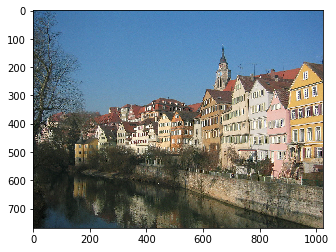

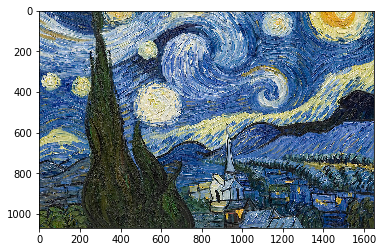

In [139]:
# Load and preprocess images
images = (Image.open(content_path), Image.open(style_path))
transformed_images = [input_transforms(i) for i in images]
if torch.cuda.is_available():
    transformed_images = (i.unsqueeze(0).cuda() for i in transformed_images)
else:
    transformed_images = (i.unsqueeze(0) for i in transformed_images)
content_image, style_image = transformed_images

for img in images:
    imshow(img)
    show()

In [140]:
# Create the model
model = StyleTransfer(content_layers=content_layers, style_layers=style_layers)
for param in model.parameters():
    param.requires_grad_(False)
if torch.cuda.is_available():
    model.cuda()

# Initialize optimization process
if init_from_content:
    output = content_image.clone().requires_grad_(True)
else:
    output = torch.randn(content_image.size()).type_as(content_image.data).requires_grad_(True)

optimizer = optim.LBFGS([output])

# Get target features for both the content and style
content_targets = [f.detach() for f in model(content_image)[0]]
style_targets = [gram_matrix(f).detach() for f in model(style_image)[1]]

## Style transfer

In [141]:
try:
    for epoch in range(epochs+1):
        content_output, style_output = model(output)
                
        if torch.cuda.is_available():
            content_loss = [content_weights[i]*nn.MSELoss().cuda()(F, content_targets[i]) for i,F in enumerate(content_output)]
            style_loss = [style_weights[i]*nn.MSELoss().cuda()(gram_matrix(F), style_targets[i]) for i,F in enumerate(style_output)]
        else:
            content_loss = [content_weights[i]*nn.MSELoss()(F, content_targets[i]) for i,F in enumerate(content_output)]
            style_loss = [style_weights[i]*nn.MSELoss()(gram_matrix(F), style_targets[i]) for i,F in enumerate(style_output)]
        
        loss = sum(content_loss+style_loss)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step(lambda: loss)
        
        if epoch % show_every == 0:
            print("#{}: Content loss = {}, Style loss = {}, Overall = {}".format(epoch, sum(content_loss).item(), sum(style_loss).item(), loss.item()))
            img = output_transforms(output.clone().data[0].cpu().squeeze())
            img.save(output_pattern.format(epoch))
            #imshow(img)
            #show()
        else:
            print("#{}".format(epoch))
except KeyboardInterrupt:
    print("Manual interruption")

#0: Content loss = 0.0, Style loss = 794261376.0, Overall = 794261376.0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11
#12
#13
#14
#15
#16
#17
#18
#19
#20: Content loss = 181997.71875, Style loss = 5641883.5, Overall = 5823881.0
#21
#22
#23
#24
#25
#26
#27
#28
#29
#30
#31
#32
#33
#34
#35
#36
#37
#38
#39
#40: Content loss = 193591.53125, Style loss = 1517904.125, Overall = 1711495.625
#41
#42
#43
#44
#45
#46
#47
#48
#49
#50
#51
#52
#53
#54
#55
#56
#57
#58
#59
#60: Content loss = 195176.390625, Style loss = 696737.125, Overall = 891913.5625
#61
#62
#63
#64
#65
#66
#67
#68
#69
#70
#71
#72
#73
#74
#75
#76
#77
#78
#79
#80: Content loss = 193971.234375, Style loss = 404122.5, Overall = 598093.6875
#81
#82
#83
#84
#85
#86
#87
#88
#89
#90
#91
#92
#93
#94
#95
#96
#97
#98
#99
#100: Content loss = 189658.859375, Style loss = 258536.0, Overall = 448194.8125
#101
#102
#103
#104
#105
#106
#107
#108
#109
#110
#111
#112
#113
#114
#115
#116
#117
#118
#119
#120: Content loss = 185907.65625, Style loss = 197166.5937

## TODO

* vérifier la validité des résultats par rapport à l'implémentation de l'auteur
* cas du BGR vs. RGB ?
* normaliser : avec ou sans réduction ?
* améliorations de l'article
* avg loss vs. max loss ?
* vérifier que tout ce qui doit être sous cuda est sous cuda
